In [1]:
# This code load the question and label
import pandas as pd
import json
import numpy as np

from sklearn.model_selection import train_test_split
# Load the CSV file
def load_csv(file_path):
    return pd.read_csv(file_path)
    
def filter_answers(df):
    # Use a regular expression to filter rows
    # The regex '^[A-Z]$' matches a single uppercase letter
    return df[df['Answer'].str.match(r'^[A-Z]$', na=False)]

file_path = 'NEJM_All_Questions_And_Answers.csv'  
df = load_csv(file_path)
df = filter_answers(df)
train_dfs = []
test_dfs = []

print(df['Subject'].unique())

['Hypertension' 'Pregnancy and Kidney Disease'
 'Primary & Secondary Glomerular Diseases'
 'Disorders of Divalent Ions Renal Bone Disease & Nephrolithiasis'
 'ESRD & Dialysis' 'Electrolyte Acid-Base Disorders'
 'Acute Kidney Injury & Critical Care Nephrology'
 'Interventional Nephrology & Dialysis Therapy'
 'Disorders of Divalent Ions, Renal Bone Disease and Nephrolithiasis'
 'Secondary Glomerular Disease' 'End Stage Renal Disease & Dialysis'
 'Primary Glomerular Disease'
 'Infection Control & Prevention in Outpatient Hemodialysis Facilities'
 'Chronic Kidney Disease and Progression' 'Transplantation'
 'Primary and Secondary Glomerular Diseases' 'End-Stage Kidney Disease'
 'Electrolytes and Acid-Base Disorders' 'Chronic Kidney Disease'
 'Disorder of Divalent Ions Renal Bone Disease and Nephrolithiasis']


In [1]:
# This code load the question and label
import pandas as pd
import json
import numpy as np

from sklearn.model_selection import train_test_split
# Load the CSV file
def load_csv(file_path):
    return pd.read_csv(file_path)
    
def filter_answers(df):
    # Use a regular expression to filter rows
    # The regex '^[A-Z]$' matches a single uppercase letter
    return df[df['Answer'].str.match(r'^[A-Z]$', na=False)]

file_path = 'NEJM_All_Questions_And_Answers.csv'  
df = load_csv(file_path)
df = filter_answers(df)
train_dfs = []
test_dfs = []

for subject in df['Subject'].unique():
    subject_df = df[df['Subject'] == subject]
    train_df, test_df = train_test_split(subject_df, test_size=0.3, random_state=42)
    train_dfs.append(train_df)
    test_dfs.append(test_df)

train_set = pd.concat(train_dfs).reset_index(drop=True)
test_set = pd.concat(test_dfs).reset_index(drop=True)



In [2]:
# Concatenate fields for training and test sets
train_set['concatenated'] = np.where(
    train_set['Context'] != '',  # Condition
    train_set['Context'] + " " + train_set['Question'] + " " + train_set['Choices'] + " The answer is: " + train_set['Answer'],
    train_set['Question'] + " " + train_set['Choices'] + " The answer is: " + train_set['Answer'].astype(str)  # If context is empty
)

# Modify test_set concatenation to handle empty context
test_set['concatenated'] = np.where(
    test_set['Context'] != '',  # Condition
    test_set['Context'] + " " + test_set['Question'] + " " + test_set['Choices'],
    test_set['Question'] + " " + test_set['Choices']  # If context is empty
)
train_set = train_set.dropna(subset=['concatenated'])
test_set = test_set.dropna(subset=['concatenated'])
train_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)
# Display the resulting dataframes
print("Training Set")
print(train_set[['concatenated']])
print("\nTest Set")
print(test_set[['concatenated']])

Training Set
                                          concatenated
0    You are seeing a 31-year-old woman with autoso...
1    \nA 33-year-old man undergoes whole genome sin...
2    You are seeing a 32-year-old black woman for a...
3    \nA 44-year-old woman has recently received a ...
4    \nA 72-year-old woman with hypertension comes ...
..                                                 ...
510  \nA 62-year-old woman with ESKD has been recei...
511  \nA 58-year-old man with ESKD secondary to typ...
512  \nA 72-year-old woman with history of hyperten...
513  \nAn 84-year-old woman with creatinine 1.8 mg/...
514  \nA 72-year-old woman has CKD stage 5 (not yet...

[515 rows x 1 columns]

Test Set
                                          concatenated
0    \nYou are asked to give a public health presen...
1    \nA novel antihypertensive therapy is develope...
2    \nYou have been following a 68-year-old man fo...
3    A 56-year-old black woman is evaluated for ina...
4    \nA 48-year-o

# Embedding

In [3]:
import openai
import time
openai.api_key = ""

def generate_embeddings_in_batches(data_frame, batch_size=10):
    if 'embeddings' not in data_frame.columns:
        data_frame['embeddings'] = pd.Series([[]] * len(data_frame))  # Initialize with empty lists
    total_batches = len(data_frame) // batch_size + (1 if len(data_frame) % batch_size != 0 else 0)
    
    for i in range(total_batches):
        # Slice the batch based on actual size
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(data_frame))
        batch = data_frame.iloc[start_idx:end_idx]
        inputs = batch['concatenated'].tolist()
        try:
            # Make the API call
            response = openai.embeddings.create(
                model="text-embedding-3-large",
                input=inputs,
                encoding_format="float"
            )
            
            # Extract embeddings from the response and ensure it's directly list of embeddings
            embeddings = [item.embedding for item in response.data]
            # Print useful information before assignment
            print(f"Batch {i + 1}/{total_batches}:")
            print(f"Start Index: {start_idx}, End Index: {end_idx}")
            print(f"Number of Embeddings: {len(embeddings)}")
            print(f"DataFrame Slice Length: {len(data_frame.loc[start_idx:end_idx-1])}")
            # Correctly assign embeddings to the DataFrame
            
            # Assign embeddings to the appropriate rows using a loop
            for j, embedding in enumerate(embeddings):
                data_frame.at[start_idx + j, 'embeddings'] = embedding
            time.sleep(1)
        except Exception as e:
            print(f"Failed to process batch {i+1}: {str(e)}")
            print("Error batch data:", batch)

def dump_embeddings_to_json(data_frame, filename):
    # Simplify the dataframe to contain only the necessary columns and convert to JSON
    with open(filename, 'w') as f:
        json.dump(data_frame.to_dict(orient='records'), f, indent=4)

# Assuming you have the 'train_set' and 'test_set' dataframes ready with a 'concatenated' column
generate_embeddings_in_batches(train_set)
generate_embeddings_in_batches(test_set)

dump_embeddings_to_json(train_set, 'train_embeddings.json')
dump_embeddings_to_json(test_set, 'test_embeddings.json')


Batch 1/52:
Start Index: 0, End Index: 10
Number of Embeddings: 10
DataFrame Slice Length: 10
Batch 2/52:
Start Index: 10, End Index: 20
Number of Embeddings: 10
DataFrame Slice Length: 10
Batch 3/52:
Start Index: 20, End Index: 30
Number of Embeddings: 10
DataFrame Slice Length: 10
Batch 4/52:
Start Index: 30, End Index: 40
Number of Embeddings: 10
DataFrame Slice Length: 10
Batch 5/52:
Start Index: 40, End Index: 50
Number of Embeddings: 10
DataFrame Slice Length: 10
Batch 6/52:
Start Index: 50, End Index: 60
Number of Embeddings: 10
DataFrame Slice Length: 10
Batch 7/52:
Start Index: 60, End Index: 70
Number of Embeddings: 10
DataFrame Slice Length: 10
Batch 8/52:
Start Index: 70, End Index: 80
Number of Embeddings: 10
DataFrame Slice Length: 10
Batch 9/52:
Start Index: 80, End Index: 90
Number of Embeddings: 10
DataFrame Slice Length: 10
Batch 10/52:
Start Index: 90, End Index: 100
Number of Embeddings: 10
DataFrame Slice Length: 10
Batch 11/52:
Start Index: 100, End Index: 110
Num

In [4]:
def load_embeddings(file_path):
    """Load embeddings from a JSON file."""
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def save_data(data, file_path):
    """Save the data to a JSON file."""
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)

def compute_cosine_similarity(vector_a, vector_b):
    """Compute cosine similarity between two vectors using OpenAI utility."""
    # Ensure vectors are np.arrays to match expected input format
    vector_a = np.array(vector_a).reshape(1, -1)
    vector_b = np.array(vector_b).reshape(1, -1)
    # Using OpenAI's cosine_similarity utility
    similarity = np.dot(vector_a, vector_b.T) / (np.linalg.norm(vector_a) * np.linalg.norm(vector_b))
    return similarity.item()

# Function to match entries and compute similarities
def match_and_compute_similarity(test_set, train_set):
    matched_test_set = test_set.copy()
    same_subject_similarities = []
    different_subject_similarities = []
    
    for index, test_row in test_set.iterrows():
        # Get the subject of the test entry
        test_subject = test_row['Subject']
        
        # Filter train_set by same and different subjects
        same_subject_train_set = train_set[train_set['Subject'] == test_subject]
        different_subject_train_set = train_set[train_set['Subject'] != test_subject]
        
        # Randomly select one entry from each set
        same_subject_entry = same_subject_train_set.sample(n=1).iloc[0]
        different_subject_entry = different_subject_train_set.sample(n=1).iloc[0]
        
        # Calculate cosine similarities
        same_subject_similarity = compute_cosine_similarity(test_row['embeddings'], same_subject_entry['embeddings'])
        different_subject_similarity = compute_cosine_similarity(test_row['embeddings'], different_subject_entry['embeddings'])
        
        # Append similarities to the lists
        same_subject_similarities.append(same_subject_similarity)
        different_subject_similarities.append(different_subject_similarity)
        
        # Add the entries to the test set for comparison
        matched_test_set.at[index, 'same_subject_entry'] = same_subject_entry['concatenated']
        matched_test_set.at[index, 'same_subject_similarity'] = same_subject_similarity
        matched_test_set.at[index, 'different_subject_entry'] = different_subject_entry['concatenated']
        matched_test_set.at[index, 'different_subject_similarity'] = different_subject_similarity

    # Add the similarities as new columns in the test set
    matched_test_set['same_subject_similarity'] = same_subject_similarities
    matched_test_set['different_subject_similarity'] = different_subject_similarities
    
    return matched_test_set

# Match entries and compute similarities
matched_test_set = match_and_compute_similarity(test_set, train_set)

# Display the updated test set with similarities
print(matched_test_set)


       ID                                            Context  \
0    5699  \nYou are asked to give a public health presen...   
1    5708  \nA novel antihypertensive therapy is develope...   
2    5685  \nYou have been following a 68-year-old man fo...   
3    2475  A 56-year-old black woman is evaluated for ina...   
4    5704  \nA 48-year-old man with suspected masked hype...   
..    ...                                                ...   
227  5842  \nA 48-year-old patient with CKD stage 4 secon...   
228  5843  \nYou are teaching a group of medical resident...   
229  5856  \nA 62-year-old man with primary focal segment...   
230  5834  \nA 72-year-old hemodialysis patient is found ...   
231  5861  \nYou asked to see a 35-year-old man with recu...   

                                              Question  \
0    Which of the following statements is correct r...   
1    Which of the following is the most likely mech...   
2    Which of the following is the best response to...   

In [5]:
with open("test_set_match.json", 'w') as f:
    json.dump(matched_test_set.to_dict(orient='records'), f, indent=4)

# Inference: get generated answer

In [11]:

import time
import json
import openai
openai.api_key = ""
def generate_gpt_answer(data, filename):
    generated_responses = []
    
    for idx, row in data.iterrows():
        print(row)
        question = row['concatenated']
        id = row['ID']
        same_subject_context = row['same_subject_entry']
        different_subject_context = row['different_subject_entry']
        
        # Generate a response without context
        messages = [
            {"role": "system", "content": """
                You will be given a question. Your task is to select the most appropriate answer from the choices provided. Make sure your response starts with the letter of your choice (A,B,C,D,E). For example, if you choose option A, your response should start with 'A'.
            """},
            {"role": "user", "content": question}
        ]
        response = openai.chat.completions.create(
            model="gpt-4-1106-preview",
            temperature=1.0,
            max_tokens=1000,
            messages=messages,
        )
        response_no_context = {
            'id': id,
            'question': question,
            'context': "no_context",
            'response': response.choices[0].message.content,
        }
        generated_responses.append(response_no_context)
        time.sleep(30)

        # Generate a response with same subject context
        messages = [
            {"role": "system", "content": """
                You will be given a question. Your task is to select the most appropriate answer from the choices provided. Make sure your response starts with the letter of your choice (A,B,C,D,E). For example, if you choose option A, your response should start with 'A'.
            """},
            {"role": "assistant", "content": "Context: " + same_subject_context},
            {"role": "user", "content": question}
        ]
        response = openai.chat.completions.create(
            model="gpt-4-1106-preview",
            temperature=1.0,
            max_tokens=1000,
            messages=messages,
        )
        response_same_subject = {
            'id': id,
            'question': question,
            'context': "same_subject",
            'response': response.choices[0].message.content,
        }
        generated_responses.append(response_same_subject)
        time.sleep(30)

        # Generate a response with different subject context
        messages = [
            {"role": "system", "content": """
                You will be given a question. Your task is to select the most appropriate answer from the choices provided. Make sure your response starts with the letter of your choice (A,B,C,D,E). For example, if you choose option A, your response should start with 'A'.
            """},
            {"role": "assistant", "content": "Context: " + different_subject_context},
            {"role": "user", "content": question}
        ]
        response = openai.chat.completions.create(
            model="gpt-4-1106-preview",
            temperature=1.0,
            max_tokens=1000,
            messages=messages,
        )
        response_different_subject = {
            'id': id,
            'question': question,
            'context': "different_subject",
            'response': response.choices[0].message.content,
        }
        generated_responses.append(response_different_subject)
        time.sleep(10)

    with open(filename, 'w') as outfile:
        json.dump(generated_responses, outfile, indent=4)

    return generated_responses



In [12]:
generated_answer = generate_gpt_answer(matched_test_set,'gpt_responses.json')


ID                                                                           5699
Context                         \nYou are asked to give a public health presen...
Question                        Which of the following statements is correct r...
Choices                         1. Number of hypertension-related deaths incre...
Answer                                                                          D
Solution                                                                 temp nan
Subject                                                              Hypertension
concatenated                    \nYou are asked to give a public health presen...
embeddings                      [-0.0024227826, 0.034840796, -0.010376601, 0.0...
same_subject_entry              \nA 46-year-old man presents to his primary ca...
same_subject_similarity                                                  0.507721
different_subject_entry         A 65-year-old man is assessed in the emergency...
different_subjec

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_similarity_scores_by_id(data_list, target_id):
    for item in data_list:
        if item['ID'] == target_id:
            return item['same_subject_similarity'], item['different_subject_similarity']
    return None, None

def load_json_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

    
def filter_answers(df):
    return df[df['Answer'].str.match(r'^[A-Z]$', na=False)]

file_path = 'test_set_match.json'  
df = load_json_data(file_path)
df = pd.DataFrame(df)
df.set_index('ID', inplace=True)


def load_results(filename, df):
    data_c = []
    data_nc = []

    with open(filename, 'r') as f:
        v_t = json.load(f)
        for v in v_t:
            answer = v['response'][0]
            correctness = (answer == df.loc[int(v['id']), 'Answer'])
            context = v['context']
            
            if context == "no_context":
                similarity = 0
                data_nc.append({
                    'id': v['id'],
                    'answer': answer,
                    'correctness': correctness,
                    'context': context,
                    'similarity': similarity
                })
            elif context == "same_subject":
                similarity = df.loc[int(v['id']), 'same_subject_similarity']
                data_c.append({
                    'id': v['id'],
                    'answer': answer,
                    'correctness': correctness,
                    'context': context,
                    'similarity': similarity
                })
            elif context == "different_subject":
                similarity = df.loc[int(v['id']), 'different_subject_similarity']
                data_c.append({
                    'id': v['id'],
                    'answer': answer,
                    'correctness': correctness,
                    'context': context,
                    'similarity': similarity
                })

    data_c = pd.DataFrame(data_c)
    data_nc = pd.DataFrame(data_nc)
    
    return data_c, data_nc


data_c, data_nc = load_results("gpt_responses.json",df)




In [2]:
print(data_c)
print(data_nc)

       id answer  correctness            context  similarity
0    5699      D         True       same_subject    0.507721
1    5699      C        False  different_subject    0.249955
2    5708      B         True       same_subject    0.418010
3    5708      B         True  different_subject    0.363773
4    5685      D         True       same_subject    0.377467
..    ...    ...          ...                ...         ...
459  5856      A         True  different_subject    0.516718
460  5834      C         True       same_subject    0.540281
461  5834      A        False  different_subject    0.415713
462  5861      B         True       same_subject    0.542535
463  5861      B         True  different_subject    0.674397

[464 rows x 5 columns]
       id answer  correctness     context  similarity
0    5699      C        False  no_context           0
1    5708      B         True  no_context           0
2    5685      D         True  no_context           0
3    2475      B        Fals

similarity_bin
0.19      1
0.31     45
0.44    197
0.56    172
0.69     42
0.81      6
0.94      1
Name: count, dtype: int64


/var/folders/y0/5n71953n2_76_0v3gh0g_rxr0000gn/T/ipykernel_14081/752309945.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_per_bin = merged_data.groupby('similarity_bin')['improvement'].agg(['mean', 'std', 'count'])


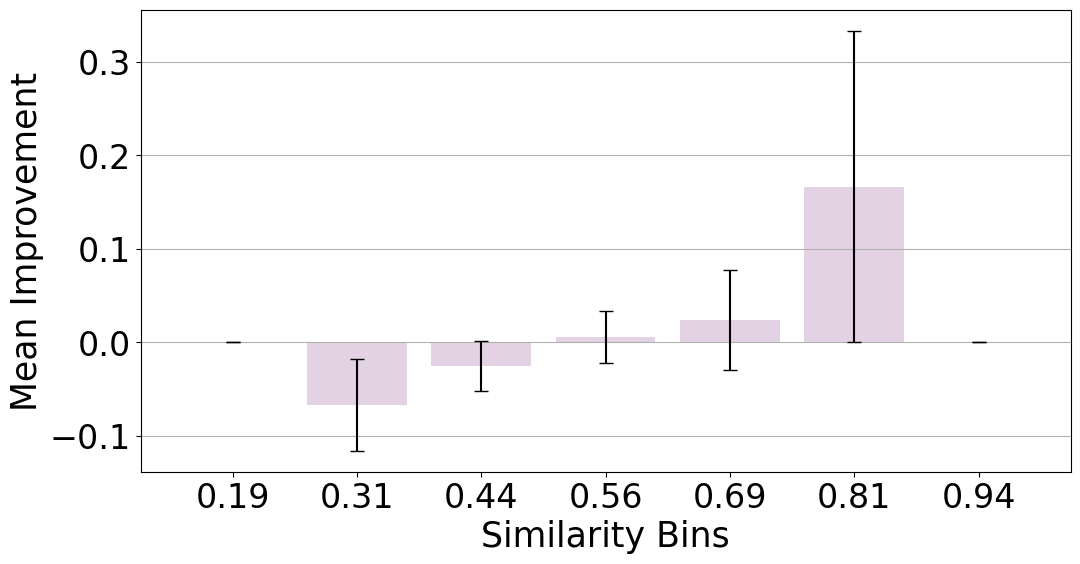

In [3]:
# Merge data_c and data_nc on 'id'
merged_data = pd.merge(data_c, data_nc, on='id', suffixes=('_c', '_nc'))

# Calculate improvement
merged_data['improvement'] = merged_data['correctness_c'].astype(int) - merged_data['correctness_nc'].astype(int)

# Define bins that cover the entire range of 'similarity' values
bins = np.linspace(0.125, 1, num=8)
bin_labels = [f"{(bins[i] + bins[i + 1]) / 2:.2f}" for i in range(len(bins) - 1)]
merged_data['similarity_bin'] = pd.cut(merged_data['similarity_c'], bins, labels=bin_labels)

# Calculate mean improvement per bin
stats_per_bin = merged_data.groupby('similarity_bin')['improvement'].agg(['mean', 'std', 'count'])
stats_per_bin['sem'] = stats_per_bin['std'] / np.sqrt(stats_per_bin['count'])
print(stats_per_bin['count'])
# Plotting the results
plt.figure(figsize=(12, 6))

# Ensure there are no NaN values; fill with 0 if necessary
stats_per_bin = stats_per_bin.fillna(0)

# Adding error bars; capsize adds horizontal lines at the top of the error bars
plt.bar(stats_per_bin.index, stats_per_bin['mean'], yerr=stats_per_bin['sem'], capsize=5, color='#D8BFD8', alpha=0.7)

plt.xlabel('Similarity Bins', fontsize=25)
plt.ylabel('Mean Improvement', fontsize=25)
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)

plt.grid(axis='y')
plt.show()